# Polymer Property Prediction: GNN vs Tree-Based Approaches

This notebook compares two fundamentally different approaches for predicting polymer properties from SMILES:

1. **Graph Neural Network (GNN)** - Learns directly from molecular graph structure
2. **Tree-Based Models** - Uses engineered molecular descriptors

**Targets:** Tg, FFV, Tc, Density, Rg

**Evaluation:** Weighted MAE (wMAE)

---
## 1. Setup & Imports

In [5]:
! pip install torch_geometric
! pip install rdkit==2023.9.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 57.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: rdkit
    Found existing installation: rdkit 2025.9.4
    Uninstalling rdkit-2025.9.4:
      Successfully uninstalled rdkit-2025.9.4


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# RDKit
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit.Chem import rdmolops
RDLogger.DisableLog('rdApp.*')

# PyTorch & PyG
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.loader import DataLoader

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu126
CUDA available: True
Using device: cuda


---
## 2. Load & Explore Data

In [7]:
# Load data
train_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (7973, 7)
Test shape: (3, 2)


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [8]:
# Target columns
TARGETS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Check missing values per target
print("Missing values per target:")
for col in TARGETS:
    n_missing = train_df[col].isna().sum()
    n_valid = train_df[col].notna().sum()
    print(f"  {col:>8}: {n_valid:>5} valid, {n_missing:>5} missing ({100*n_missing/len(train_df):.1f}%)")

Missing values per target:
        Tg:   511 valid,  7462 missing (93.6%)
       FFV:  7030 valid,   943 missing (11.8%)
        Tc:   737 valid,  7236 missing (90.8%)
   Density:   613 valid,  7360 missing (92.3%)
        Rg:   614 valid,  7359 missing (92.3%)


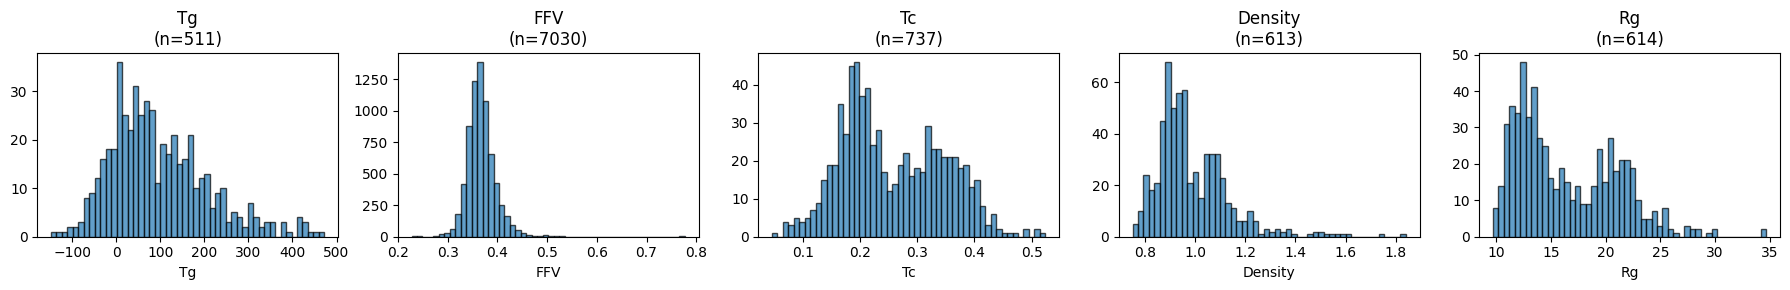

In [9]:
# Visualize target distributions
fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for i, col in enumerate(TARGETS):
    data = train_df[col].dropna()
    axes[i].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}\n(n={len(data)})')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [10]:
# Clean training data
train_cleaned = train_df.dropna(subset=TARGETS, how='all')  # Keep rows with at least 1 target
train_cleaned = train_cleaned.drop_duplicates(subset='SMILES')
train_cleaned = train_cleaned.reset_index(drop=True)

print(f"Original: {len(train_df)} → Cleaned: {len(train_cleaned)} samples")

Original: 7973 → Cleaned: 7973 samples


---
## 3. Common Utilities

In [11]:
def smiles_to_mol(smiles):
    """Convert SMILES to RDKit Mol, handling polymer wildcards"""
    cleaned = smiles.replace('*', '[*]')
    return Chem.MolFromSmiles(cleaned)


def compute_wmae(y_true, y_pred, train_df):
    """
    Compute weighted MAE as per competition metric.
    
    Weight formula: w_i = (1/range_i) * K * sqrt(1/n_i) / sum(sqrt(1/n_j))
    """
    ranges = []
    counts = []
    
    for col in TARGETS:
        data = train_df[col].dropna()
        ranges.append(data.max() - data.min())
        counts.append(len(data))
    
    ranges = np.array(ranges)
    counts = np.array(counts)
    K = len(TARGETS)
    
    sqrt_inv_n = np.sqrt(1 / counts)
    weights = (1 / ranges) * K * sqrt_inv_n / sqrt_inv_n.sum()
    
    # Compute weighted MAE
    total_error = 0.0
    n_samples = len(y_true)
    
    for i in range(n_samples):
        for j in range(5):
            if not np.isnan(y_true[i, j]):
                total_error += weights[j] * abs(y_pred[i, j] - y_true[i, j])
    
    return total_error / n_samples, dict(zip(TARGETS, weights))


print("Utility functions defined!")

Utility functions defined!


---
# APPROACH 1: Graph Neural Network (GNN)
---

The GNN approach treats each molecule as a graph where:
- **Nodes** = Atoms (with features like atomic number, hybridization, etc.)
- **Edges** = Bonds (with features like bond type, aromaticity, etc.)

The model learns to aggregate information across the molecular graph to predict properties.

## 4. GNN - Feature Extraction

In [12]:
def get_atom_features(atom):
    """
    Extract atom features (18 dimensions)
    """
    features = [
        atom.GetAtomicNum(),           # Atomic number
        atom.GetDegree(),              # Number of bonds
        atom.GetTotalNumHs(),          # Total H count
        atom.GetImplicitValence(),     # Implicit valence
        atom.GetFormalCharge(),        # Formal charge
        atom.GetMass() / 100.0,        # Atomic mass (normalized)
        int(atom.GetIsAromatic()),     # Is aromatic
        int(atom.IsInRing()),          # Is in ring
        atom.GetNumRadicalElectrons(), # Radical electrons
    ]
    
    # Hybridization one-hot (5 types)
    hyb = atom.GetHybridization()
    hyb_types = [
        Chem.HybridizationType.SP,
        Chem.HybridizationType.SP2,
        Chem.HybridizationType.SP3,
        Chem.HybridizationType.SP3D,
        Chem.HybridizationType.SP3D2,
    ]
    features.extend([int(hyb == h) for h in hyb_types])
    
    # Common atoms one-hot (4 types)
    symbol = atom.GetSymbol()
    features.extend([int(symbol == a) for a in ['C', 'N', 'O', 'S']])
    
    return features  # 18 features total


def get_bond_features(bond):
    """
    Extract bond features (7 dimensions)
    """
    features = [
        float(bond.GetBondTypeAsDouble()),  # Bond order
        int(bond.GetIsConjugated()),        # Is conjugated
        int(bond.IsInRing()),               # Is in ring
        int(bond.GetIsAromatic()),          # Is aromatic
        int(bond.GetStereo() != Chem.BondStereo.STEREONONE),  # Has stereo
    ]
    
    # Bond type one-hot
    bt = bond.GetBondType()
    features.extend([
        int(bt == Chem.BondType.SINGLE),
        int(bt == Chem.BondType.DOUBLE),
    ])
    
    return features  # 7 features total


# Test feature extraction
test_mol = smiles_to_mol(train_cleaned['SMILES'].iloc[0])
print(f"Atom features dim: {len(get_atom_features(test_mol.GetAtoms()[0]))}")
print(f"Bond features dim: {len(get_bond_features(test_mol.GetBonds()[0]))}")

Atom features dim: 18
Bond features dim: 7


## 5. GNN - Dataset & Model

In [13]:
class PolymerGraphDataset(Dataset):
    """
    PyTorch Geometric Dataset for polymer molecules
    """
    def __init__(self, df, targets=TARGETS, include_targets=True):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.targets = targets
        self.include_targets = include_targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mol = smiles_to_mol(row['SMILES'])
        
        if mol is None:
            raise ValueError(f"Invalid SMILES at index {idx}")
        
        # Node features
        x = torch.tensor([get_atom_features(a) for a in mol.GetAtoms()], dtype=torch.float)
        
        # Edge features
        edge_index, edge_attr = [], []
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            feat = get_bond_features(bond)
            edge_index.extend([[i, j], [j, i]])
            edge_attr.extend([feat, feat])
        
        if len(edge_index) == 0:
            edge_index = torch.zeros((2, 0), dtype=torch.long)
            edge_attr = torch.zeros((0, 7), dtype=torch.float)
        else:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # Targets
        if self.include_targets:
            y = torch.tensor(
                [row[t] if pd.notna(row[t]) else float('nan') for t in self.targets],
                dtype=torch.float
            ).unsqueeze(0)
        else:
            y = torch.full((1, len(self.targets)), float('nan'))
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


# Test dataset
test_dataset = PolymerGraphDataset(train_cleaned.head(5))
print(f"Sample graph: {test_dataset[0]}")

Sample graph: Data(x=[19, 18], edge_index=[2, 38], edge_attr=[38, 7], y=[1, 5])


In [14]:
class GNNModel(nn.Module):
    """
    Graph Neural Network using GINE convolutions with residual connections
    """
    def __init__(self, node_dim=18, edge_dim=7, hidden_dim=256, num_layers=4, dropout=0.15):
        super().__init__()
        
        # Initial embeddings
        self.node_embed = nn.Sequential(
            nn.Linear(node_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
        )
        
        self.edge_embed = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.SiLU(),
        )
        
        # GNN layers
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 2),
                nn.BatchNorm1d(hidden_dim * 2),
                nn.SiLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim * 2, hidden_dim),
            )
            self.convs.append(GINEConv(mlp, edge_dim=hidden_dim))
            self.norms.append(nn.LayerNorm(hidden_dim))
        
        # Output layers (using 3 pooling strategies)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 5),  # 5 targets
        )
    
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Embed
        x = self.node_embed(x)
        edge_attr = self.edge_embed(edge_attr)
        
        # Message passing with residuals
        for conv, norm in zip(self.convs, self.norms):
            x_new = conv(x, edge_index, edge_attr)
            x_new = norm(x_new)
            x = x + F.silu(x_new)  # Residual
        
        # Multiple pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x_sum = global_add_pool(x, batch)
        x_pooled = torch.cat([x_mean, x_max, x_sum], dim=1)
        
        return self.fc(x_pooled)


# Test model
model = GNNModel()
print(f"GNN parameters: {sum(p.numel() for p in model.parameters()):,}")

GNN parameters: 1,542,021


## 6. GNN - Training

In [15]:
def masked_mse_loss(pred, target):
    """MSE loss ignoring NaN targets"""
    mask = ~torch.isnan(target)
    if mask.sum() == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    return F.mse_loss(pred[mask], target[mask])


def masked_mae(pred, target):
    """MAE ignoring NaN targets"""
    mask = ~torch.isnan(target)
    if mask.sum() == 0:
        return 0.0
    return torch.abs(pred[mask] - target[mask]).mean().item()

In [16]:
# Prepare data with scaling
gnn_train_df = train_cleaned.copy()

# Scale targets
gnn_scaler = StandardScaler()
gnn_scaler.fit(gnn_train_df[TARGETS])
gnn_train_df[TARGETS] = gnn_scaler.transform(gnn_train_df[TARGETS])

# Create dataset and split
gnn_dataset = PolymerGraphDataset(gnn_train_df)

idx = list(range(len(gnn_dataset)))
train_idx, temp_idx = train_test_split(idx, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_loader = DataLoader([gnn_dataset[i] for i in train_idx], batch_size=32, shuffle=True)
val_loader = DataLoader([gnn_dataset[i] for i in val_idx], batch_size=32)
test_loader = DataLoader([gnn_dataset[i] for i in test_idx], batch_size=32)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 6378, Val: 797, Test: 798


In [17]:
# Training loop
gnn_model = GNNModel(hidden_dim=256, num_layers=4, dropout=0.15).to(device)
optimizer = torch.optim.AdamW(gnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

EPOCHS = 100
PATIENCE = 15

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
history = {'train_loss': [], 'val_mae': []}

print("Training GNN...")
for epoch in range(1, EPOCHS + 1):
    # Train
    gnn_model.train()
    train_losses = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gnn_model(data)
        loss = masked_mse_loss(out, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    scheduler.step()
    
    # Validate
    gnn_model.eval()
    val_maes = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = gnn_model(data)
            val_maes.append(masked_mae(out, data.y))
    
    train_loss = np.mean(train_losses)
    val_mae = np.mean(val_maes)
    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_mae)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f}")
    
    # Early stopping
    if val_mae < best_val_loss:
        best_val_loss = val_mae
        best_model_state = gnn_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model
gnn_model.load_state_dict(best_model_state)
print(f"\nBest validation MAE: {best_val_loss:.4f}")

Training GNN...
Epoch 010 | Train Loss: 0.3269 | Val MAE: 0.3134
Epoch 020 | Train Loss: 0.2362 | Val MAE: 0.2730
Epoch 030 | Train Loss: 0.1555 | Val MAE: 0.2636
Epoch 040 | Train Loss: 0.1307 | Val MAE: 0.2287
Epoch 050 | Train Loss: 0.1032 | Val MAE: 0.2309
Epoch 060 | Train Loss: 0.0851 | Val MAE: 0.2182
Epoch 070 | Train Loss: 0.0701 | Val MAE: 0.2078
Epoch 080 | Train Loss: 0.0580 | Val MAE: 0.2068
Epoch 090 | Train Loss: 0.0535 | Val MAE: 0.2040
Epoch 100 | Train Loss: 0.0553 | Val MAE: 0.2013

Best validation MAE: 0.1993


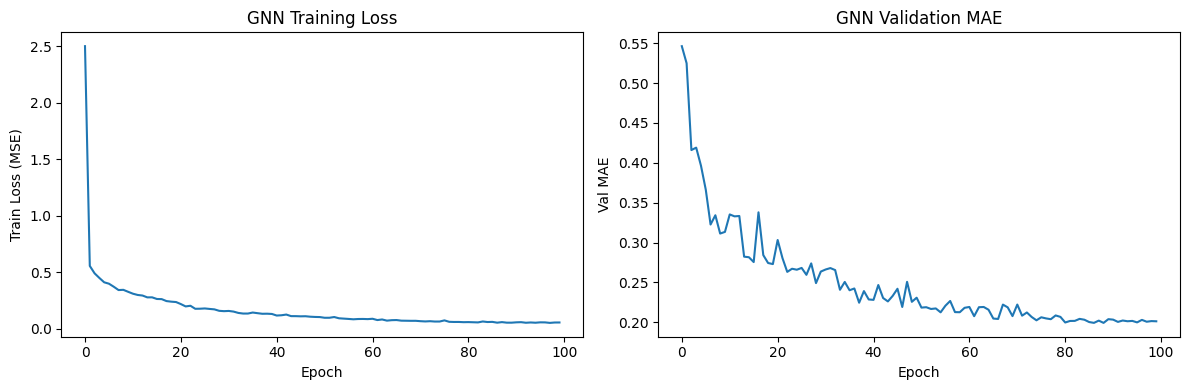

In [18]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss (MSE)')
ax1.set_title('GNN Training Loss')

ax2.plot(history['val_mae'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Val MAE')
ax2.set_title('GNN Validation MAE')

plt.tight_layout()
plt.show()

In [19]:
# Evaluate GNN on test set
gnn_model.eval()
gnn_preds, gnn_targets = [], []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = gnn_model(data)
        gnn_preds.append(out.cpu())
        gnn_targets.append(data.y.cpu())

gnn_preds = torch.cat(gnn_preds, dim=0).numpy()
gnn_targets = torch.cat(gnn_targets, dim=0).numpy()

# Inverse transform
gnn_preds_unscaled = gnn_scaler.inverse_transform(gnn_preds)
gnn_targets_unscaled = gnn_scaler.inverse_transform(gnn_targets)

# Per-target MAE
print("\n" + "="*50)
print("GNN TEST RESULTS (Original Scale)")
print("="*50)

gnn_results = {}
for i, name in enumerate(TARGETS):
    mask = ~np.isnan(gnn_targets_unscaled[:, i])
    if mask.sum() > 0:
        mae = mean_absolute_error(gnn_targets_unscaled[mask, i], gnn_preds_unscaled[mask, i])
        r2 = r2_score(gnn_targets_unscaled[mask, i], gnn_preds_unscaled[mask, i])
        gnn_results[name] = {'MAE': mae, 'R2': r2, 'N': mask.sum()}
        print(f"{name:>8}: MAE = {mae:>10.4f}, R² = {r2:.4f}, N = {mask.sum()}")

# Compute wMAE
gnn_wmae, weights = compute_wmae(gnn_targets_unscaled, gnn_preds_unscaled, train_cleaned)
print(f"\n{'wMAE':>8}: {gnn_wmae:.6f}")


GNN TEST RESULTS (Original Scale)
      Tg: MAE =    46.0465, R² = 0.6455, N = 48
     FFV: MAE =     0.0049, R² = 0.9280, N = 703
      Tc: MAE =     0.0296, R² = 0.7519, N = 74
 Density: MAE =     0.0294, R² = 0.8330, N = 64
      Rg: MAE =     1.3997, R² = 0.8288, N = 65

    wMAE: 0.022313


---
# APPROACH 2: Tree-Based Models
---

The tree-based approach:
1. Extracts ~150+ molecular descriptors using RDKit
2. Trains separate models for each target
3. Uses ensemble of ExtraTrees, GradientBoosting, RandomForest

## 7. Tree Models - Feature Engineering

In [20]:
def compute_rdkit_descriptors(smiles):
    """
    Compute all RDKit 2D descriptors for a SMILES string
    """
    mol = smiles_to_mol(smiles)
    if mol is None:
        return {name: np.nan for name, _ in Descriptors.descList}
    
    result = {}
    for name, func in Descriptors.descList:
        try:
            result[name] = func(mol)
        except:
            result[name] = np.nan
    
    return result


def compute_morgan_fingerprint(smiles, radius=2, n_bits=512):
    """
    Compute Morgan fingerprint as dictionary
    """
    mol = smiles_to_mol(smiles)
    if mol is None:
        return {f'morgan_{i}': 0 for i in range(n_bits)}
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    return {f'morgan_{i}': int(fp[i]) for i in range(n_bits)}


def compute_graph_features(smiles):
    """
    Compute graph-based features
    """
    mol = smiles_to_mol(smiles)
    if mol is None:
        return {'graph_diameter': np.nan, 'avg_shortest_path': np.nan, 'num_cycles': np.nan}
    
    try:
        dmat = rdmolops.GetDistanceMatrix(mol)
        return {
            'graph_diameter': np.max(dmat),
            'avg_shortest_path': np.mean(dmat),
            'num_cycles': len(Chem.GetSSSR(mol)),
        }
    except:
        return {'graph_diameter': np.nan, 'avg_shortest_path': np.nan, 'num_cycles': np.nan}

In [21]:
def prepare_features(df, use_morgan=True, use_descriptors=True, verbose=True):
    """
    Prepare full feature matrix from SMILES
    """
    all_features = []
    
    for idx, smiles in enumerate(df['SMILES']):
        if verbose and idx % 1000 == 0:
            print(f"  Processing {idx}/{len(df)}...")
        
        row = {}
        
        if use_morgan:
            row.update(compute_morgan_fingerprint(smiles))
        
        if use_descriptors:
            row.update(compute_rdkit_descriptors(smiles))
            row.update(compute_graph_features(smiles))
        
        all_features.append(row)
    
    features_df = pd.DataFrame(all_features)
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    if verbose:
        print(f"Feature matrix shape: {features_df.shape}")
    
    return features_df

In [26]:
# Compute features for training data
print("Computing features for training data...")
tree_features = prepare_features(train_cleaned, use_morgan=True, use_descriptors=True)

# ===== ADD THIS CLEANING BLOCK =====
# Replace inf with NaN
tree_features = tree_features.replace([np.inf, -np.inf], np.nan)

# Remove columns with too many NaNs
nan_threshold = 0.5
valid_cols = tree_features.columns[tree_features.isna().mean() < nan_threshold]
tree_features = tree_features[valid_cols]

# Remove zero variance columns
non_zero_var = tree_features.std() > 0
tree_features = tree_features.loc[:, non_zero_var]

# Fill remaining NaNs with median (column-wise)
tree_features = tree_features.fillna(tree_features.median())

# Clip extreme values (optional but recommended)
for col in tree_features.columns:
    p01 = tree_features[col].quantile(0.01)
    p99 = tree_features[col].quantile(0.99)
    tree_features[col] = tree_features[col].clip(p01, p99)

print(f"Final feature matrix: {tree_features.shape}")
# ===================================

Computing features for training data...
  Processing 0/7973...
  Processing 1000/7973...
  Processing 2000/7973...
  Processing 3000/7973...
  Processing 4000/7973...
  Processing 5000/7973...
  Processing 6000/7973...
  Processing 7000/7973...
Feature matrix shape: (7973, 732)
Final feature matrix: (7973, 707)


## 8. Tree Models - Training

In [27]:
def train_tree_ensemble(X, y, target_name):
    """
    Train ensemble of tree models for a single target
    """
    # Remove NaN targets
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    
    # Fill NaN features with median
    X_clean = np.nan_to_num(X_clean, nan=0.0)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )
    
    models = {}
    preds = {}
    
    # ExtraTrees
    et = ExtraTreesRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=15)
    et.fit(X_train, y_train)
    preds['ExtraTrees'] = et.predict(X_test)
    models['ExtraTrees'] = et
    
    # GradientBoosting
    gb = GradientBoostingRegressor(n_estimators=200, random_state=42, max_depth=5, learning_rate=0.1)
    gb.fit(X_train, y_train)
    preds['GradientBoosting'] = gb.predict(X_test)
    models['GradientBoosting'] = gb
    
    # RandomForest
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=15)
    rf.fit(X_train, y_train)
    preds['RandomForest'] = rf.predict(X_test)
    models['RandomForest'] = rf
    
    # Ensemble (simple average)
    ensemble_pred = np.mean(list(preds.values()), axis=0)
    
    # Results
    print(f"\n{target_name} (N={len(y_clean)}):")
    for name, pred in preds.items():
        mae = mean_absolute_error(y_test, pred)
        print(f"  {name:20s}: MAE = {mae:.4f}")
    
    ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_r2 = r2_score(y_test, ensemble_pred)
    print(f"  {'ENSEMBLE':20s}: MAE = {ensemble_mae:.4f}, R² = {ensemble_r2:.4f}")
    
    return models, {'MAE': ensemble_mae, 'R2': ensemble_r2, 'N': len(y_clean)}, (X_test, y_test, ensemble_pred)

In [28]:
# Train models for all targets
print("="*60)
print("TRAINING TREE MODELS")
print("="*60)

X = tree_features.values
feature_names = tree_features.columns.tolist()

tree_models = {}
tree_results = {}
tree_test_data = {}

for target in TARGETS:
    y = train_cleaned[target].values
    models, results, test_data = train_tree_ensemble(X, y, target)
    tree_models[target] = models
    tree_results[target] = results
    tree_test_data[target] = test_data

TRAINING TREE MODELS

Tg (N=511):
  ExtraTrees          : MAE = 51.3980
  GradientBoosting    : MAE = 57.1348
  RandomForest        : MAE = 53.5802
  ENSEMBLE            : MAE = 53.3055, R² = 0.5274

FFV (N=7030):
  ExtraTrees          : MAE = 0.0071
  GradientBoosting    : MAE = 0.0068
  RandomForest        : MAE = 0.0078
  ENSEMBLE            : MAE = 0.0069, R² = 0.7151

Tc (N=737):
  ExtraTrees          : MAE = 0.0304
  GradientBoosting    : MAE = 0.0302
  RandomForest        : MAE = 0.0289
  ENSEMBLE            : MAE = 0.0293, R² = 0.7472

Density (N=613):
  ExtraTrees          : MAE = 0.0313
  GradientBoosting    : MAE = 0.0317
  RandomForest        : MAE = 0.0374
  ENSEMBLE            : MAE = 0.0325, R² = 0.7196

Rg (N=614):
  ExtraTrees          : MAE = 1.6456
  GradientBoosting    : MAE = 1.9122
  RandomForest        : MAE = 1.7691
  ENSEMBLE            : MAE = 1.7258, R² = 0.6649


In [29]:
# Summary of tree results
print("\n" + "="*50)
print("TREE MODELS TEST RESULTS")
print("="*50)

for target in TARGETS:
    r = tree_results[target]
    print(f"{target:>8}: MAE = {r['MAE']:>10.4f}, R² = {r['R2']:.4f}, N = {r['N']}")


TREE MODELS TEST RESULTS
      Tg: MAE =    53.3055, R² = 0.5274, N = 511
     FFV: MAE =     0.0069, R² = 0.7151, N = 7030
      Tc: MAE =     0.0293, R² = 0.7472, N = 737
 Density: MAE =     0.0325, R² = 0.7196, N = 613
      Rg: MAE =     1.7258, R² = 0.6649, N = 614


## 9. Feature Importance Analysis

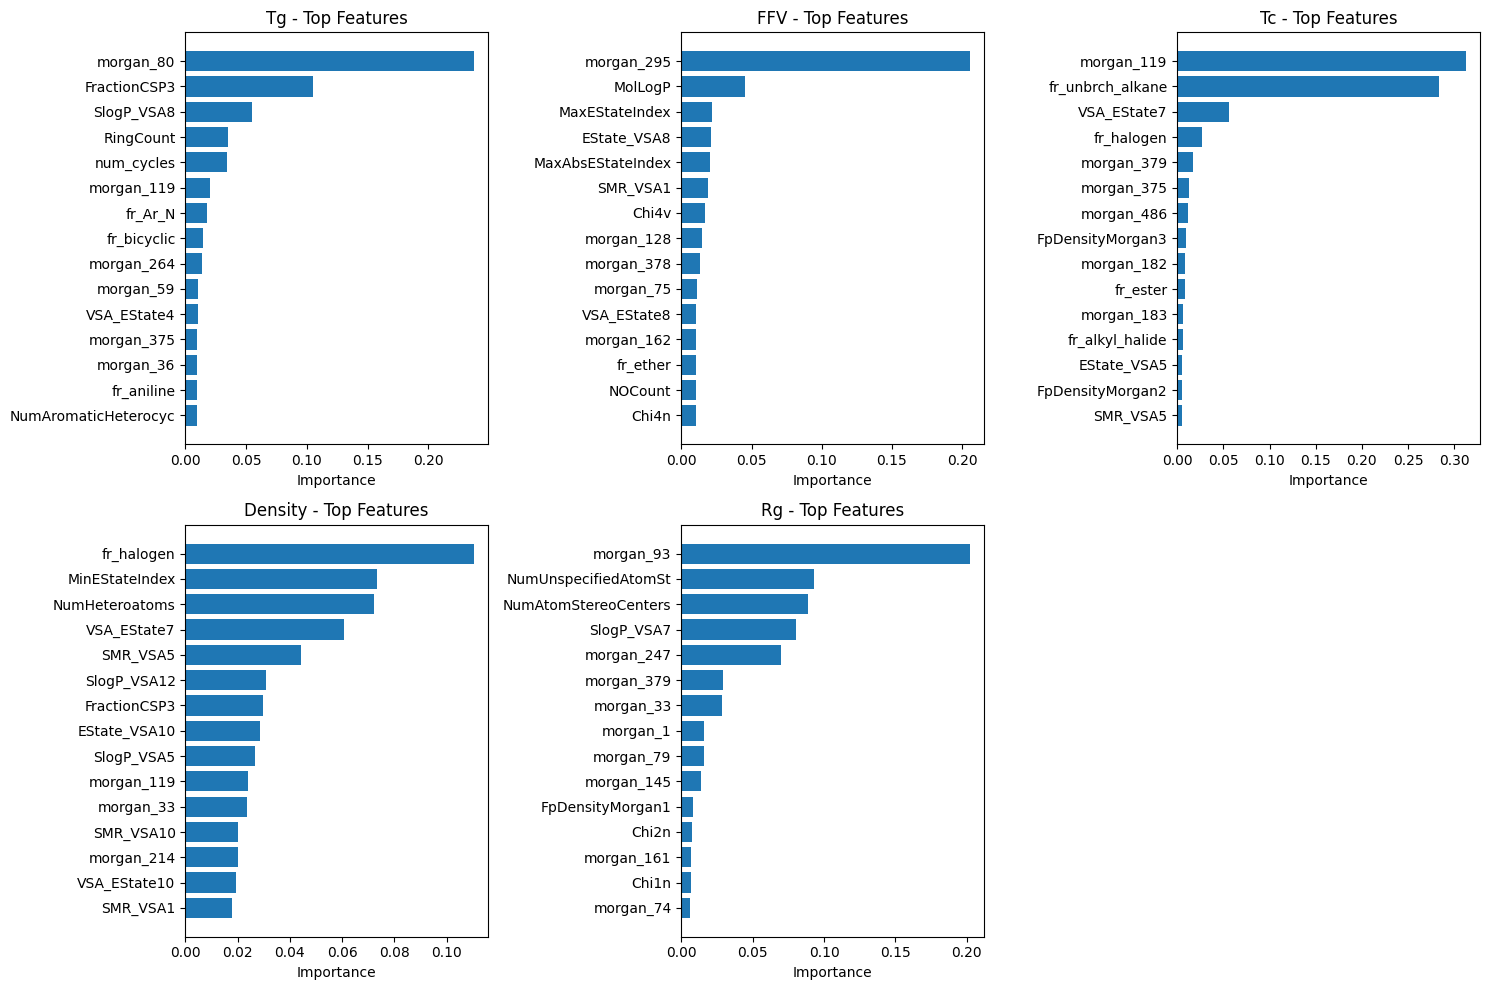

In [30]:
# Plot top features for each target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, target in enumerate(TARGETS):
    # Get feature importance from ExtraTrees
    et_model = tree_models[target]['ExtraTrees']
    importance = et_model.feature_importances_
    
    # Top 15 features
    top_idx = np.argsort(importance)[-15:]
    top_names = [feature_names[i][:20] for i in top_idx]  # Truncate names
    top_importance = importance[top_idx]
    
    axes[idx].barh(top_names, top_importance)
    axes[idx].set_title(f'{target} - Top Features')
    axes[idx].set_xlabel('Importance')

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

---
# COMPARISON: GNN vs Tree Models
---

In [31]:
# Create comparison table
print("="*70)
print("COMPARISON: GNN vs TREE MODELS")
print("="*70)
print(f"{'Target':<10} {'GNN MAE':>12} {'Tree MAE':>12} {'Winner':>10} {'Diff %':>10}")
print("-"*70)

comparison_data = []

for target in TARGETS:
    gnn_mae = gnn_results[target]['MAE']
    tree_mae = tree_results[target]['MAE']
    
    winner = 'GNN' if gnn_mae < tree_mae else 'Tree'
    diff_pct = 100 * (tree_mae - gnn_mae) / tree_mae
    
    comparison_data.append({
        'Target': target,
        'GNN_MAE': gnn_mae,
        'Tree_MAE': tree_mae,
        'Winner': winner,
        'Diff_Pct': diff_pct
    })
    
    print(f"{target:<10} {gnn_mae:>12.4f} {tree_mae:>12.4f} {winner:>10} {diff_pct:>+9.1f}%")

comparison_df = pd.DataFrame(comparison_data)
print("-"*70)

COMPARISON: GNN vs TREE MODELS
Target          GNN MAE     Tree MAE     Winner     Diff %
----------------------------------------------------------------------
Tg              46.0465      53.3055        GNN     +13.6%
FFV              0.0049       0.0069        GNN     +28.6%
Tc               0.0296       0.0293       Tree      -1.1%
Density          0.0294       0.0325        GNN      +9.5%
Rg               1.3997       1.7258        GNN     +18.9%
----------------------------------------------------------------------


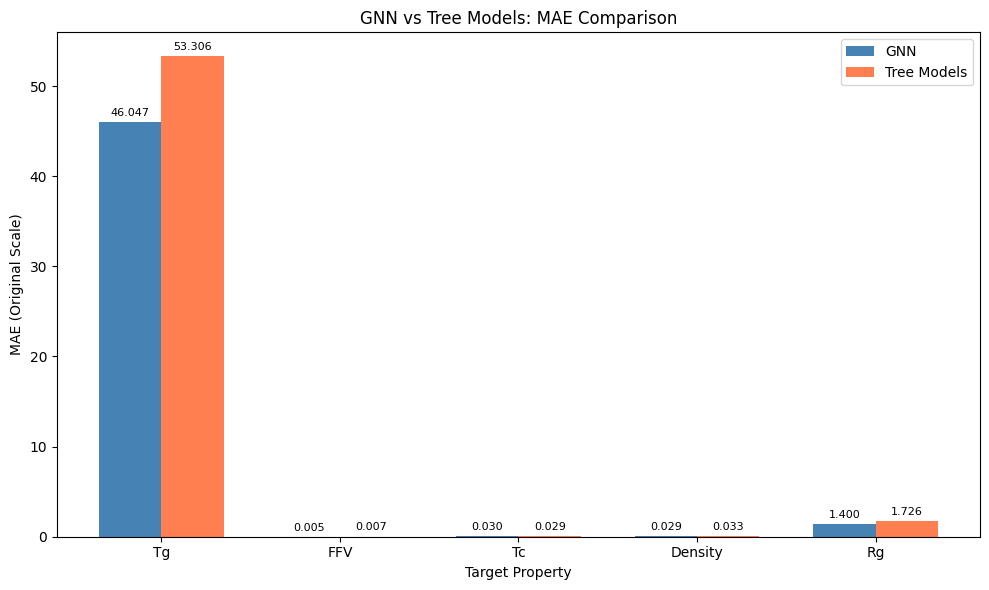

In [32]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(TARGETS))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['GNN_MAE'], width, label='GNN', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['Tree_MAE'], width, label='Tree Models', color='coral')

ax.set_xlabel('Target Property')
ax.set_ylabel('MAE (Original Scale)')
ax.set_title('GNN vs Tree Models: MAE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(TARGETS)
ax.legend()

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [33]:
# R² comparison
print("\nR² COMPARISON:")
print(f"{'Target':<10} {'GNN R²':>10} {'Tree R²':>10}")
print("-"*35)

for target in TARGETS:
    gnn_r2 = gnn_results[target]['R2']
    tree_r2 = tree_results[target]['R2']
    print(f"{target:<10} {gnn_r2:>10.4f} {tree_r2:>10.4f}")


R² COMPARISON:
Target         GNN R²    Tree R²
-----------------------------------
Tg             0.6455     0.5274
FFV            0.9280     0.7151
Tc             0.7519     0.7472
Density        0.8330     0.7196
Rg             0.8288     0.6649


---
# ENSEMBLE: Combining Both Approaches
---

In [34]:
# For a proper ensemble, we need predictions on the same test set
# Here we'll demonstrate the concept with weighted averaging

def predict_ensemble(gnn_model, tree_models, test_df, tree_features, gnn_scaler, 
                     weights={'gnn': 0.4, 'tree': 0.6}):
    """
    Generate ensemble predictions combining GNN and Tree models
    """
    # GNN predictions
    test_dataset = PolymerGraphDataset(test_df, include_targets=False)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    gnn_model.eval()
    gnn_preds = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = gnn_model(data)
            gnn_preds.append(out.cpu().numpy())
    
    gnn_preds = np.vstack(gnn_preds)
    gnn_preds = gnn_scaler.inverse_transform(gnn_preds)
    
    # Tree predictions
    X_test = np.nan_to_num(tree_features.values, nan=0.0)
    tree_preds = np.zeros((len(test_df), 5))
    
    for i, target in enumerate(TARGETS):
        target_preds = []
        for model in tree_models[target].values():
            target_preds.append(model.predict(X_test))
        tree_preds[:, i] = np.mean(target_preds, axis=0)
    
    # Weighted ensemble
    ensemble_preds = weights['gnn'] * gnn_preds + weights['tree'] * tree_preds
    
    return gnn_preds, tree_preds, ensemble_preds


print("Ensemble function defined!")
print("\nNote: For submission, use predict_ensemble() on the actual test set.")

Ensemble function defined!

Note: For submission, use predict_ensemble() on the actual test set.


---
# GENERATE SUBMISSION
---

In [35]:
# Prepare test features
print("Preparing test features...")
test_features = prepare_features(test_df, use_morgan=True, use_descriptors=True)

# Align columns with training features
missing_cols = set(tree_features.columns) - set(test_features.columns)
for col in missing_cols:
    test_features[col] = 0
test_features = test_features[tree_features.columns]

Preparing test features...
  Processing 0/3...
Feature matrix shape: (3, 732)


In [36]:
# Generate predictions
gnn_test_preds, tree_test_preds, ensemble_preds = predict_ensemble(
    gnn_model, tree_models, test_df, test_features, gnn_scaler,
    weights={'gnn': 0.4, 'tree': 0.6}
)

print(f"Predictions shape: {ensemble_preds.shape}")

Predictions shape: (3, 5)


In [37]:
# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'Tg': ensemble_preds[:, 0] + 273.15,  # Convert to Kelvin
    'FFV': ensemble_preds[:, 1],
    'Tc': ensemble_preds[:, 2],
    'Density': ensemble_preds[:, 3],
    'Rg': ensemble_preds[:, 4],
})

submission.to_csv('submission.csv', index=False)
print("✅ Submission saved!")
submission.head()

✅ Submission saved!


,id,Tg,FFV,Tc,Density,Rg
0,1109053969,430.487923,0.374546,0.205187,1.145049,20.523431
1,1422188626,440.693816,0.376146,0.252974,1.099164,19.523835
2,2032016830,347.738133,0.353570,0.276125,1.093417,20.094949


---
# SUMMARY & CONCLUSIONS
---

In [38]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL COMPARISON:")
print(comparison_df.to_string(index=False))

print("\n🔑 KEY INSIGHTS:")
print("""  
1. GNN STRENGTHS:
   - Learns features automatically from molecular structure
   - Better at capturing long-range interactions
   - Multi-task learning can help with sparse targets

2. TREE MODEL STRENGTHS:
   - Fast training and inference
   - Interpretable (feature importance)
   - Robust to outliers
   - Works well with engineered domain features

3. ENSEMBLE BENEFITS:
   - Combines complementary strengths
   - More robust predictions
   - Often outperforms individual models
""")

print("\n📈 RECOMMENDATIONS FOR IMPROVEMENT:")
print("""  
1. Add external datasets (Tc, Tg from supplementary sources)
2. Try XGBoost/LightGBM for tree models
3. Use 5-fold CV for more robust evaluation
4. Tune ensemble weights per target
5. Add pretrained molecular embeddings (ChemBERTa)
""")

FINAL SUMMARY

📊 MODEL COMPARISON:
 Target   GNN_MAE  Tree_MAE Winner  Diff_Pct
     Tg 46.046543 53.305542    GNN 13.617718
    FFV  0.004932  0.006911    GNN 28.644458
     Tc  0.029616  0.029282   Tree -1.141122
Density  0.029448  0.032537    GNN  9.496234
     Rg  1.399672  1.725795    GNN 18.896946

🔑 KEY INSIGHTS:
  
1. GNN STRENGTHS:
   - Learns features automatically from molecular structure
   - Better at capturing long-range interactions
   - Multi-task learning can help with sparse targets

2. TREE MODEL STRENGTHS:
   - Fast training and inference
   - Interpretable (feature importance)
   - Robust to outliers
   - Works well with engineered domain features

3. ENSEMBLE BENEFITS:
   - Combines complementary strengths
   - More robust predictions
   - Often outperforms individual models


📈 RECOMMENDATIONS FOR IMPROVEMENT:
  
1. Add external datasets (Tc, Tg from supplementary sources)
2. Try XGBoost/LightGBM for tree models
3. Use 5-fold CV for more robust evaluation
4. Tune